## Predicting the Market Penetration of Alternative Fuel Stations and Vehicles - United States

## Abstract

Transportation sector is dependent on Petroleum based fuel that results in higher emission level. The United States consumes approximately 20 million barrels of petroleum per day, about three-fourths of which is used for transportation. Transportation also has a significant economic impact on American businesses and families, accounting for nearly one-sixth of the average household’s expensesPDF. Improving efficiency and reducing costs in this sector can thereby make a notable impact on our economy. 

Increased economic and energy security aren't the only benefits. Widespread use of alternative fuels and advanced vehicles could reduce the emissions that impact our air quality and public health. Production and distribution of these alternative fuels that can be economically available is a constraint for the increase in the number of alternative fuel driven vehicles. 

One known fact is "attaining environmentally beneficial transportation fuel at an affordable price" is the way of the future. This project focuses on the number of alternative fuel stations and the number alternative fuel powered  vehicles across the United States, its growth trend and developing a predictive model. 

## Import necessary packages and libraries

In [1]:
# import packages and libraries
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shapefile as shp
import re
import json
import requests
import warnings
import geopandas as gpd
import scipy.stats as stats
import string
from pygeocoder import Geocoder
from collections import defaultdict
from collections import OrderedDict
from IPython.display import HTML
from shapely.geometry import Point
from sklearn.cluster import Birch
from sklearn.exceptions import DataConversionWarning
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
import scipy.stats
import gmaps
import gmaps.datasets
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Specify formatting and ignore warnings

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {return false;}

<IPython.core.display.Javascript object>

In [3]:
# Specify Formatting
display(HTML(r"<style>.output {display: flex; \
              align-items: center; \
              text-align: center;} \
              </style>"))

In [4]:
# Ignore warnings
warnings.simplefilter(action="ignore", \
                      category=FutureWarning)

warnings.filterwarnings(action='ignore', \
                        category=DataConversionWarning)

## Load Data

Station data and vehicle inventory data has been collected from https://afdc.energy.gov/data_download/.
Data wrangling performed and saved in file Alt_Fuel_DW.ipynb from which data from the following cleaned up csv files will be loaded for Exploratory Data Analysis.

In [5]:
# Load data from cleaned csv files - (Alt_Fuel_DW.ipynb contains the Data Wrangling code)
alt_fuels_df = pd.read_csv('open_fuels.csv',parse_dates = True, error_bad_lines=False,low_memory=False)
veh_sales_df = pd.read_csv('veh_sales.csv',parse_dates = True, error_bad_lines=False,low_memory=False)

### Load Shape files
https://medium.com/@erikgreenj/mapping-us-states-with-geopandas-made-simple-d7b6e66fa20d

In [6]:
usa = gpd.read_file('shape_us_state/tl_2017_us_state.shp')

## Perform Exploratory Data Analysis

In [7]:
# Define function to aggregate and create stacked plot
def aggregate(rows,columns,df):
    column_keys = df[columns].unique()
    row_keys = df[rows].unique()

    agg = { key : [ len(df[(df[rows]==value) & (df[columns]==key)]) for value in row_keys]
               for key in column_keys }

    aggdf = pd.DataFrame(agg,index = row_keys)
    aggdf.index.rename(rows,inplace=True)

    return aggdf

Text(0.5, 1.0, 'Alternative Fuel Stations Growth Trend Over The Years Across US')

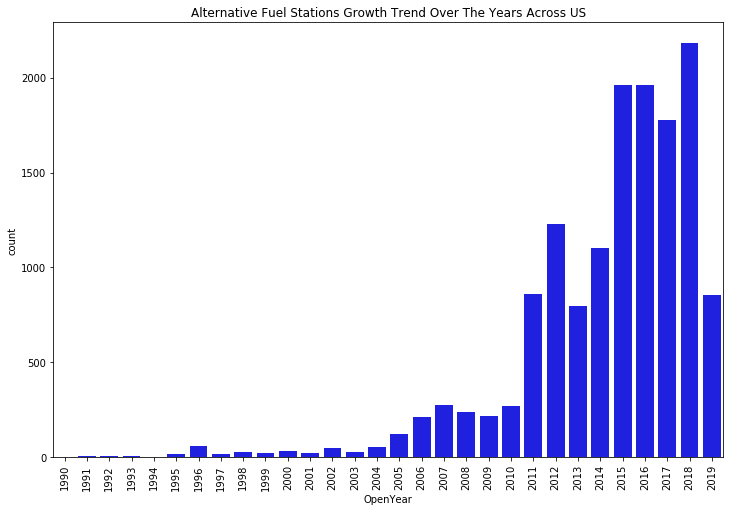

In [8]:
# Generate an sns count plot to view growth trend over the years
figure(figsize=(12,8))
sns.countplot('OpenYear', data=alt_fuels_df[alt_fuels_df.OpenYear>=1990],color='b')
plt.xticks(rotation='vertical')
plt.title('Alternative Fuel Stations Growth Trend Over The Years Across US')

The trend shows overall growth in the alternative fuel stations year on year, with remarkable growth since 2011.
This might be due to increased awareness created by Clean Cities Coalitions in the community. The mission of Clean Cities coalitions is to foster the economic, environmental, and energy security of the United States by working locally to advance affordable, domestic transportation fuels, energy efficient mobility systems, and other fuel-saving technologies and practices. Clean Cities coalitions are comprised of businesses, fuel providers, vehicle fleets, state and local government agencies, and community organizations.      
         
Note: Number of alternative fuel stations in 2019 is accumualted sum until the month of April. At this rate it is expected to surpass the total number of stations above 2500 for the year ending.

Text(0.5, 1.0, 'Top States With Alternative Fuel Stations Across US')

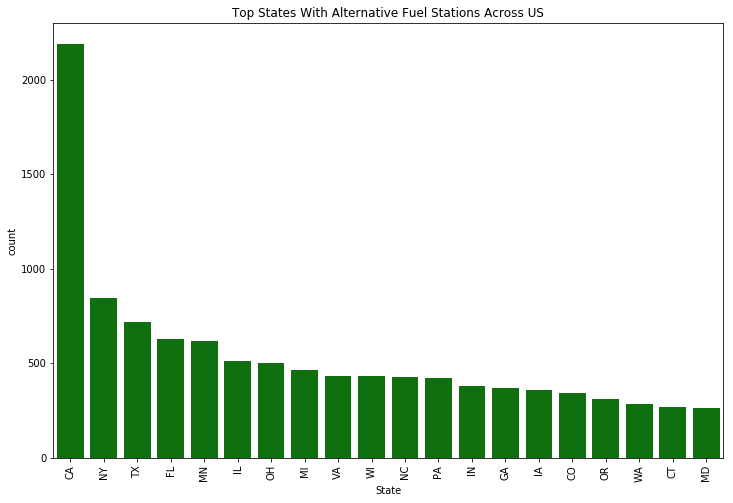

In [9]:
# Generate an sns count plot to view top states with alternative fuel stations
figure(figsize=(12,8))
sns.countplot('State', data=alt_fuels_df, order = alt_fuels_df.State.value_counts().iloc[:20].index,color='g')
plt.xticks(rotation='vertical')
plt.title('Top States With Alternative Fuel Stations Across US')

Synopsis of the above plot shows highest concentration of alternative fuel stations in California followed by New York and Texas states. Upon research State of California has launched a campaign to reduce consumption of petroleum and diesel fuels and shifting towards cleaner fuels. This campaingn is known as Low Carbon Fuel Standard (LCFS) - 
http://www.cadelivers.org/low-carbon-fuel-standard/.             
           
From 2011 to 2018 the LCFS has avoided 13.7 billion gallons of petroleum, increased 74% use of clean fuels, invested 2.8 billion in clean fuel production.                
         
The LCFS is working to transform the fuels market from one that relies almost entirely on petroleum-based fuels to a diversified one that uses a variety of alternative fuels. This market-based transition to clean, low-carbon fuels is leading to technology innovation that’s helping California meet its long term climate, clean air, and public health goals. Just as the state requirements are helping shift our electricity mix to more renewables like wind and solar, the LCFS is also delivering the clean fuels we need today and going forward.

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

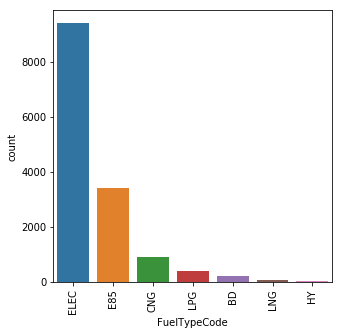

In [10]:
# Generate an sns count plot to view number of stations by fuel type
figure(figsize=(5,5))
sns.countplot('FuelTypeCode', data=alt_fuels_df, order = alt_fuels_df.FuelTypeCode.value_counts().iloc[:15].index)
plt.xticks(rotation='vertical')

Above 90% of the alternative fuel used in transportation sector is comprised of electricity and ethanol85. Among them 65% of the fuel is electric based. The reason for the high number of electric charging stations is attributed to No Tail Pipe Emissions and environmental friendly.     
             
Plug-in electric vehicles (PEVs) are capable of drawing electricity from off-board electrical power sources (generally the electricity grid) and storing it in batteries. Electricity for charging vehicles is especially cost effective if drivers are able to take advantage of off-peak residential rates offered by many utilities. In many cities, PEV drivers also have access to public charging stations at libraries, shopping centers, hospitals, and businesses. Charging infrastructure is rapidly expanding, providing drivers with the convenience, range, and confidence to meet more of their transportation needs with PEVs.        
          
The next popular alternative fuel is E85(ethanol) that is predominantly produced by fermenting and distilling starch crops mostly corn. This is 100% renewable fuel and roughly 1 acre of corn can be processed into 330 gallons of combustible ethanol.

In [11]:
# Setting up US map as an input. If you want to return states that are spread out, leave it set to true.
# If plotting bordering states and prefer to zoom in.
def state_plotter(states, us_map=True):
    # instantiate a matplotlib figure
    # to change size, use x_lim and y_lim, changing the figsize will not change the size of the map
    fig, ax = plt.subplots(figsize=(30,30))
    if us_map: # if us_map is set to True
        # The following series of statements provide control over whether Alaska and Hawaii will show up in the map.
        if 'HI' in states:
            usa[0:50].plot(ax=ax, alpha=0.3)
        elif 'AK' in states:
            usa[1:51].plot(ax=ax, alpha=0.3)
        elif 'AK' and 'HI' in states:
            usa[0:51].plot(ax=ax, alpha=0.3)
        else:
            usa[1:50].plot(ax=ax, alpha=0.3)
        # The following loop will go through the list of input state abbreviations and plot them
        for n in states:
            usa[usa.STUSPS == f'{n}'].plot(ax=ax,edgecolor='y',linewidth=2)
        # If you choose not to have the first layer of the whole US, this will plot states on their own
    elif us_map == False:
        for n in states:
            usa[usa.STUSPS == f'{n}'].plot(ax=ax,edgecolor='y',linewidth=2)

Text(111.375, 0.5, 'Latitude')

<Figure size 1080x1080 with 0 Axes>

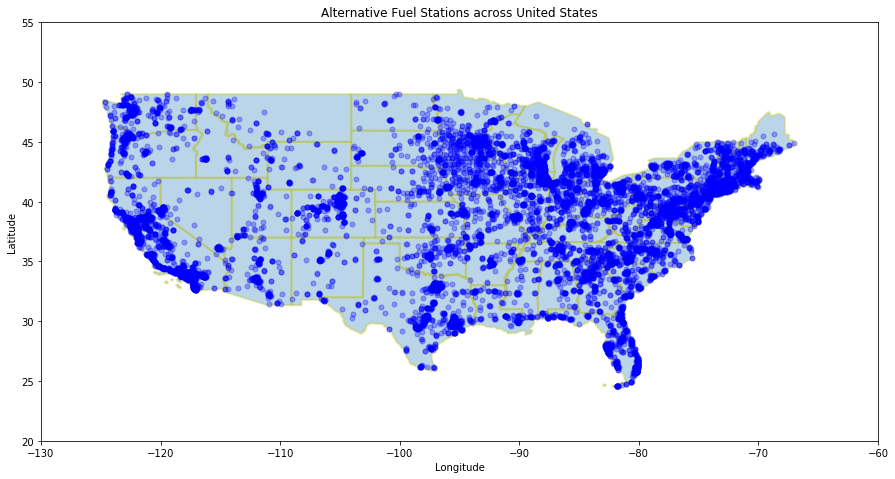

In [12]:
# Map Stations
figure(figsize=(15,15))
fig, ax = plt.subplots(figsize=(15,15))
usa.plot(ax=ax,alpha=0.3,edgecolor='y',linewidth=2)
xlim(-130,-60)
ylim(20,55)
plot(alt_fuels_df.Longitude, alt_fuels_df.Latitude,'.', ms=10,alpha=.3, color='b')
xlim(-130,-60)
ylim(20,55)
title('Alternative Fuel Stations across United States')
xlabel('Longitude')
ylabel('Latitude')

The above geographic plot shows the concentration of alternative fuel stations across United States. It clearly indicates that alternative fuel stations are popular along the coastal line and as well where the population density is high.   

Many alternative fuels exist, but few are as bountiful, easily produced and cost effective as traditional fossil fuels. The emissions impact and energy output provided by alternative fuels vary, depending on the fuel source.
 
Few commonly consumed alternative fuels include Ethanol, Natural Gas, Bio-diesel, electricity (batteries), hydrogen (fuel cells), non-fossil methane, propane and other biomass sources.

Text(0.5, 1.0, 'Alternative Fuel Stations across United States by Fuel Type')

<Figure size 2880x2160 with 0 Axes>

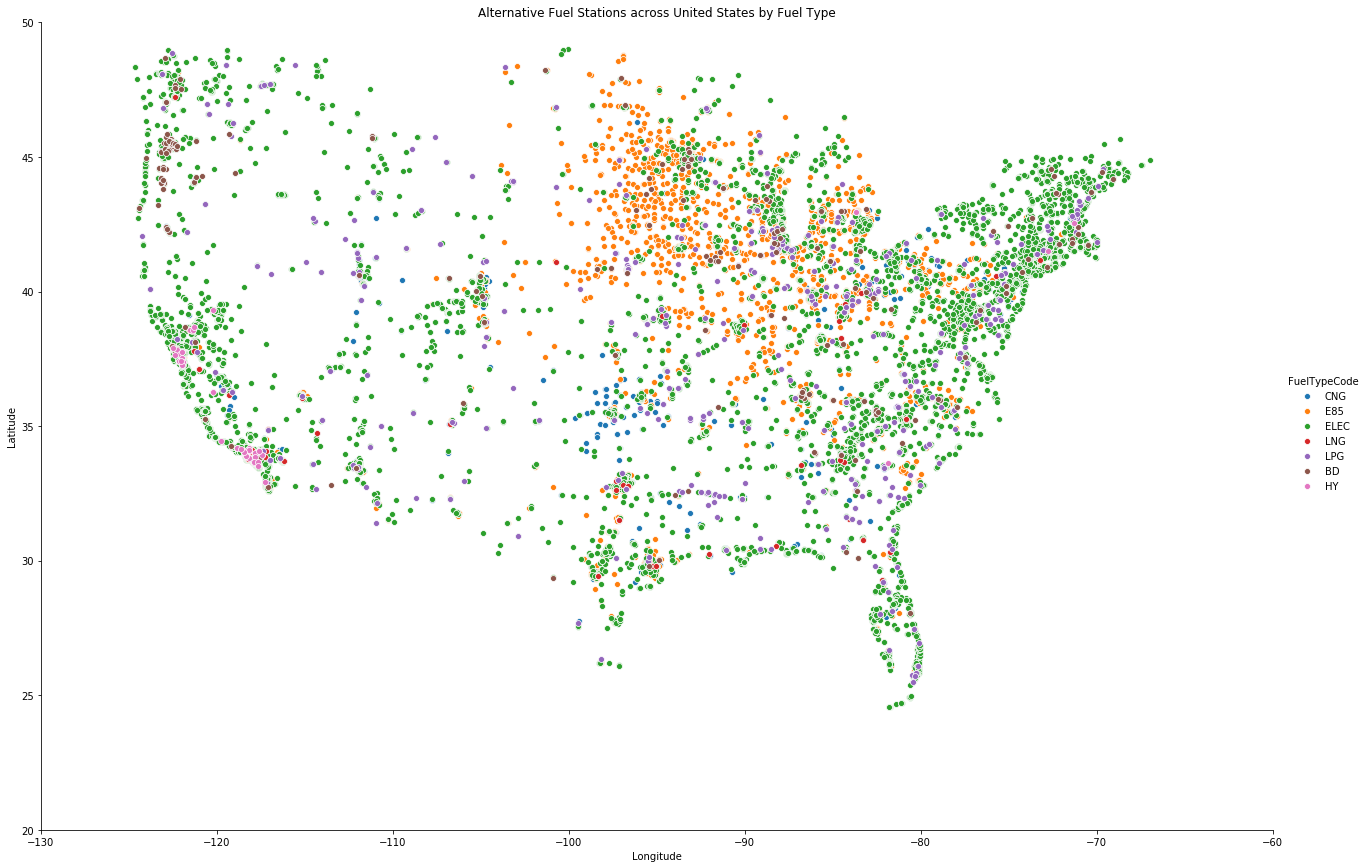

In [13]:
# Map Stations by Fuel Type
figure(figsize=(40,30))
sns.pairplot(x_vars=['Longitude'], y_vars=['Latitude'], data=alt_fuels_df,hue='FuelTypeCode', height=12, aspect=1.5)
xlim(-130,-60)
ylim(20,50)
title('Alternative Fuel Stations across United States by Fuel Type')

The above geo plot shows various types of alternative fuel stations across United States.        
Electric fuel stations are prominent along the coastline.    
E85 fuel stations are concentrated in North Central states.     
HY stations are concentrated mainly in CA along the coastline.     

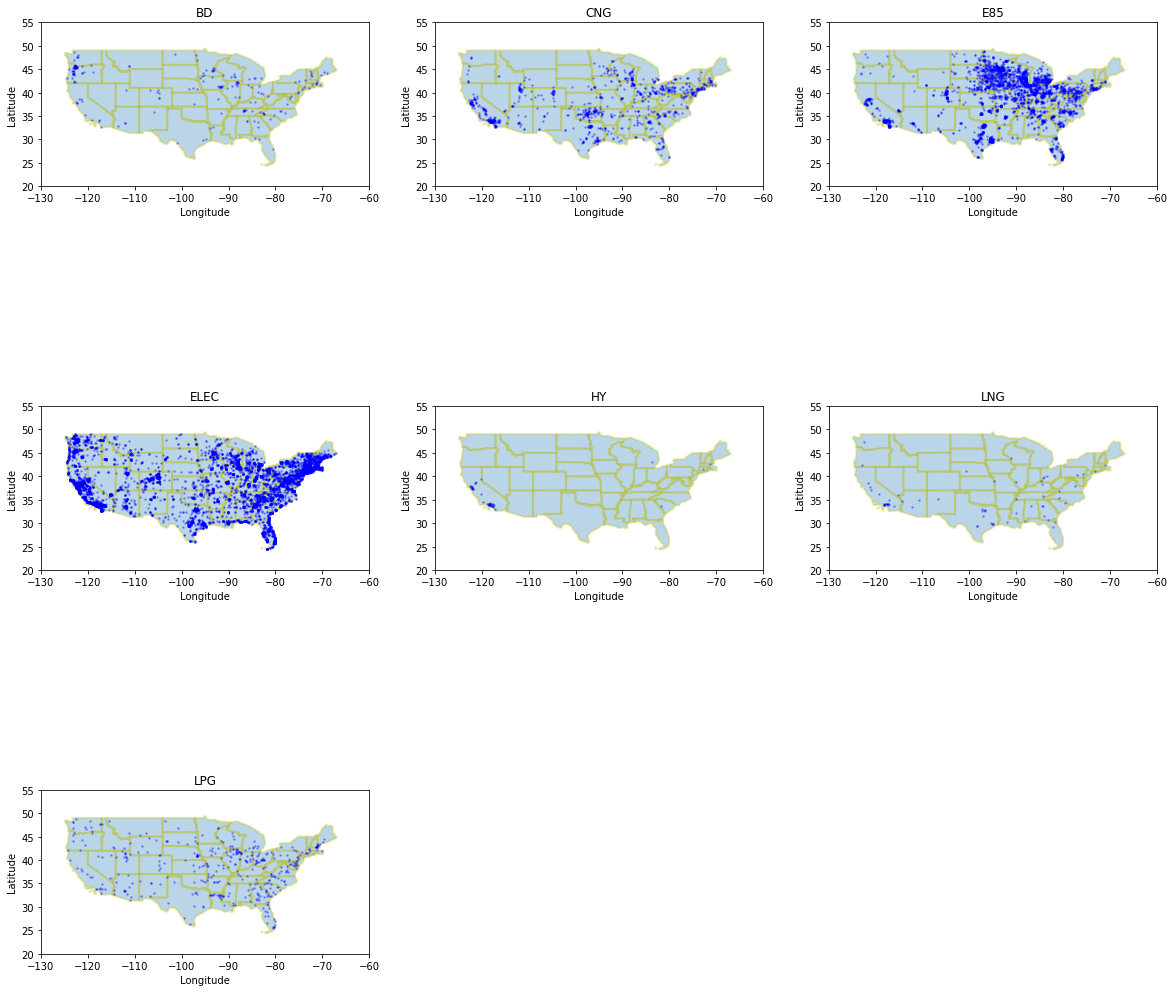

In [14]:
# Individual plots by fuel type to view distribution across the US
fig, axs = plt.subplots(3, 3,squeeze=False, figsize=(20,20))
#fig.subplots_adjust(hspace=0)
#fig.subplots_adjust(wspace=2)

for (m,n), subplot in numpy.ndenumerate(axs):
    subplot.set_xlim(-130,-60)
    subplot.set_ylim(20,55)
usa.plot(ax=axs[0,0],alpha=0.3,edgecolor='y',linewidth=2)
axs[0,0].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='BD'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='BD'],'.', ms=3,alpha=.3, color='b')
axs[0,0].set_title('BD')
usa.plot(ax=axs[0,1],alpha=0.3,edgecolor='y',linewidth=2)
axs[0,1].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='CNG'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='CNG'],'.', ms=3,alpha=.3, color='b')
axs[0,1].set_title('CNG')
usa.plot(ax=axs[0,2],alpha=0.3,edgecolor='y',linewidth=2)
axs[0,2].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='E85'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='E85'],'.', ms=3,alpha=.3, color='b')
axs[0,2].set_title('E85')
usa.plot(ax=axs[1,0],alpha=0.3,edgecolor='y',linewidth=2)
axs[1,0].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='ELEC'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='ELEC'],'.', ms=3,alpha=.3, color='b')
axs[1,0].set_title('ELEC')
usa.plot(ax=axs[1,1],alpha=0.3,edgecolor='y',linewidth=2)
axs[1,1].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='HY'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='HY'],'.', ms=3,alpha=.3, color='b')
axs[1,1].set_title('HY')
usa.plot(ax=axs[1,2],alpha=0.3,edgecolor='y',linewidth=2)
axs[1,2].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='LNG'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='LNG'],'.', ms=3,alpha=.3, color='b')
axs[1,2].set_title('LNG')
usa.plot(ax=axs[2,0],alpha=0.3,edgecolor='y',linewidth=2)
axs[2,0].plot(alt_fuels_df[alt_fuels_df.FuelTypeCode=='LPG'].Longitude, \
              alt_fuels_df.Latitude[alt_fuels_df.FuelTypeCode=='LPG'],'.', ms=3,alpha=.3, color='b')
axs[2,0].set_title('LPG')
fig.delaxes(axs[2][1])
fig.delaxes(axs[2][2])

for ax in axs.flat:
    ax.set(xlabel='Longitude', ylabel='Latitude')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
#    ax.label_outer() 

Individual plots to show the concentration of stations with respective fuel types across the United States.   
      
Biodiesel:          
Produced from vegetable oil or animal fats, the projected production of biodiesel in the US is nearly 12 billion gallons. North Carolina seems to be leading the way in widespread availability of biodiesel.       

Compressed Natural Gas:          
If you've seen a municipal bus that's powered by natural gas, it's using compresed methane. With the highest popularity in oil rich nations outside of the US, it's seeing limited use domestically.      

E85 (85% Ethanol gas):         
An ethanol fuel blend of 85% ethanol, 15% gasoline. Flex fuel vehicles can use E85. Popular in corn growing states where there are local and Federal subsidies.  

Electric vehicle charging stations:      
Heavy subsidies and the success of Tesla have increased the market viability and variety of all electric vehicles. An increase in pay-as-you-go charging stations as shown in this map make it feasible to travel for longer distances than previously possible.        
        
Hydrogen:         
A *hydrogen highway* is a chain of hydrogen-equipped filling stations and other infrastructure along a road or highway. Italy and Germany are collaborating to build a hydrogen highway between Mantua in northern Italy and Munich in southern Germany.       

Liquified Natural Gas:          
Liquified natural gas is primarily methane that has been converted to liquid for ease of storage or transport.      
        
Propane:        
With propane's wide availability and lower maintenance costs, it's an attractive option for light duty industrial vehicles.      

## Example
### Closer look at the distribution of alternative fuel stations by different fuel types in the state of California
California has the highest number of alternative fuel stations as per the data and as we can see tremendous growth in the electric fuel stations over the past years.

In [15]:
# Read CA geo json file
ca_map = gpd.read_file('ca_california_zip_codes_geo.min.json')
print(type(ca_map))
display(ca_map.head())

<class 'geopandas.geodataframe.GeoDataFrame'>


,STATEFP10,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,PARTFLG10,geometry
0,06,94601,0694601,B5,G6350,S,8410939,310703,+37.7755447,-122.2187049,N,"POLYGON ((-122.227171 37.791969, -122.226933 3..."
1,06,94501,0694501,B5,G6350,S,20539466,9005303,+37.7737968,-122.2781230,N,"POLYGON ((-122.291808 37.763008, -122.306606 3..."
2,06,94560,0694560,B5,G6350,S,35757865,60530,+37.5041413,-122.0323587,N,"POLYGON ((-122.054991 37.549595, -122.054412 3..."
3,06,94587,0694587,B5,G6350,S,51075108,0,+37.6031556,-122.0186382,N,"POLYGON ((-122.065154 37.604849, -122.064986 3..."
4,06,94580,0694580,B5,G6350,S,8929836,17052,+37.6757312,-122.1330170,N,"POLYGON ((-122.129987 37.684453, -122.129954 3..."


In [16]:
ca_map['zipcode'] = ca_map['ZCTA5CE10'].astype(numpy.int64)

In [17]:
ca_map['Latitude'] = ca_map.INTPTLAT10[1:]
ca_map['Latitude'] = ca_map.Latitude.astype(numpy.float)
ca_map['Longitude'] = ca_map.INTPTLON10[1:]
ca_map['Longitude'] = ca_map.Longitude.astype(numpy.float)

In [18]:
CA_fuel_df = alt_fuels_df[['ZIP','ID','State', 'Latitude', 'Longitude', 'FuelTypeCode']]

In [19]:
CA_fuel_df = CA_fuel_df[(CA_fuel_df['State']=='CA')]
CA_fuel_df.head()

,ZIP,ID,State,Latitude,Longitude,FuelTypeCode
44,95949,792,CA,39.200620,-121.062126,CNG
45,94583,797,CA,37.773172,-121.968239,CNG
46,95062,798,CA,36.969267,-121.999295,CNG
47,93313,801,CA,35.317617,-119.039048,CNG
48,93725,806,CA,36.721360,-119.761165,CNG


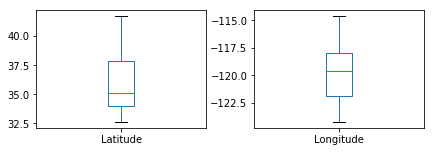

In [20]:
# Plot to check for outliers 
fig=plt.figure()
plt.subplot(2,2,1)
CA_fuel_df.Latitude.plot(kind="box")
plt.subplot(2,2,2)
CA_fuel_df.Longitude.plot(kind="box")
plt.tight_layout()

In [21]:
# Drop outliers
CA_fuel_df=CA_fuel_df[(CA_fuel_df.Latitude>30)&(CA_fuel_df.Longitude<-100)]

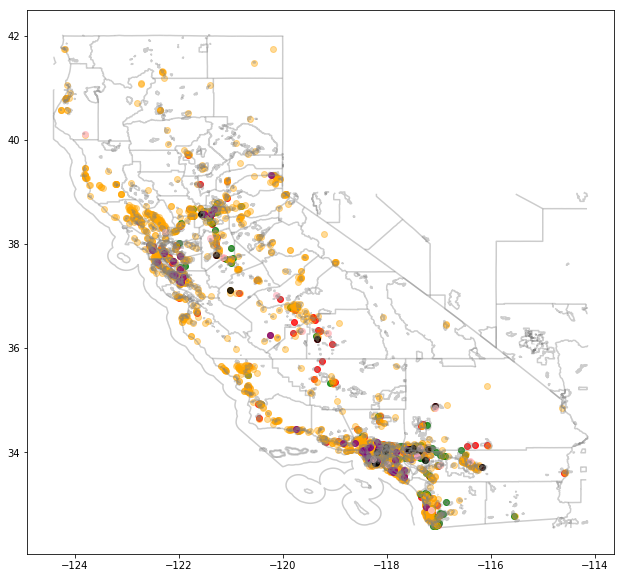

In [22]:
# geopandas plotting
crs = {'init','epsg:4326'}

geometry= [Point(xy) for xy in zip(CA_fuel_df.Longitude, CA_fuel_df.Latitude)]

fuels_geo_df = gpd.GeoDataFrame(CA_fuel_df,crs=crs, geometry=geometry)
ca_shape = gpd.read_file("california_administrative/california_administrative.shp")
fig, ax=plt.subplots(figsize=(15,10))
ca_shape.plot(ax=ax, alpha=0.4, color="grey")
fuels_geo_df[fuels_geo_df.FuelTypeCode=='BD'].plot(ax=ax, color="blue", alpha=0.8)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='CNG'].plot(ax=ax, color="r", alpha=0.8)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='E85'].plot(ax=ax, color="g", alpha=0.8)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='ELEC'].plot(ax=ax, color="orange", alpha=0.4)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='HY'].plot(ax=ax, color="purple", alpha=0.8)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='LNG'].plot(ax=ax, color="black", alpha=0.8)
fuels_geo_df[fuels_geo_df.FuelTypeCode=='LPG'].plot(ax=ax, color="pink", alpha=0.8)

In [23]:
stations = gpd.GeoDataFrame(ca_map[['GEOID10','geometry']],crs=crs,geometry='geometry')
stations.head()

,GEOID10,geometry
0,0694601,"POLYGON ((-122.227171 37.791969, -122.226933 3..."
1,0694501,"POLYGON ((-122.291808 37.763008, -122.306606 3..."
2,0694560,"POLYGON ((-122.054991 37.549595, -122.054412 3..."
3,0694587,"POLYGON ((-122.065154 37.604849, -122.064986 3..."
4,0694580,"POLYGON ((-122.129987 37.684453, -122.129954 3..."


In [24]:
# Join fuel_df and stations with geopandas sjoin
fuel_stations_df = gpd.sjoin(fuels_geo_df,stations)#Spatial join Points to polygons

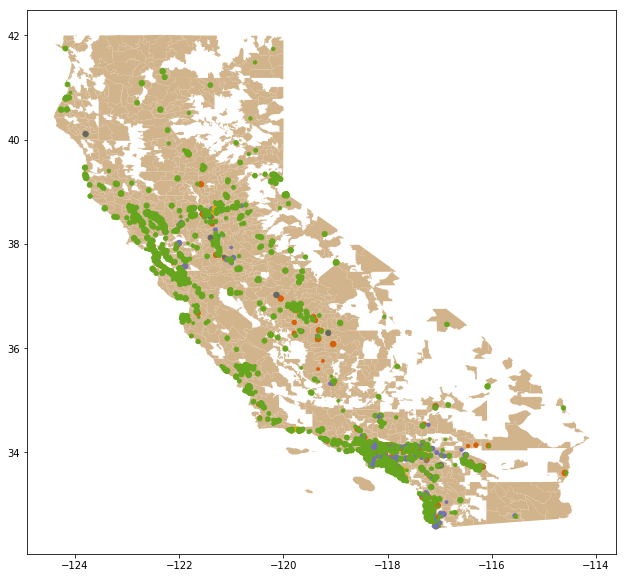

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')
stations.plot(ax=ax, color='tan')
#fuel_stations_df.plot(markersize=50, column='FuelTypeCode', cmap='Set1', ax=ax)
fuels_geo_df.plot(ax=ax,cmap='Dark2', marker='.',s=[10*3,15*3, 20*3, 25*3, 30*3, 35*3,40*3],column='FuelTypeCode')

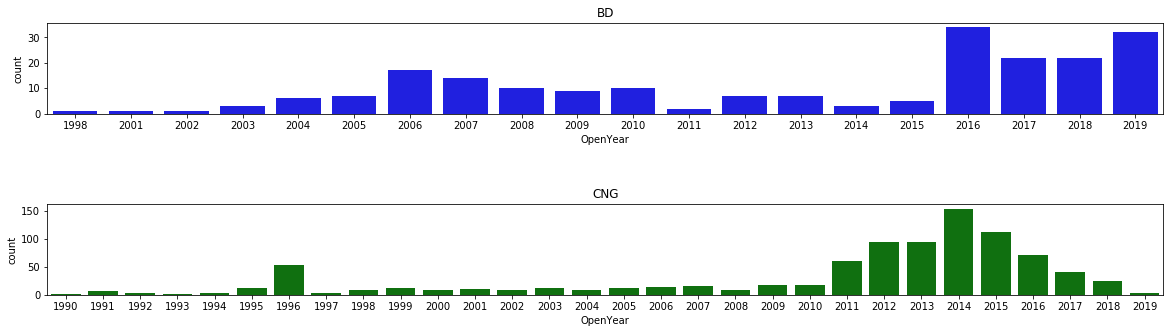

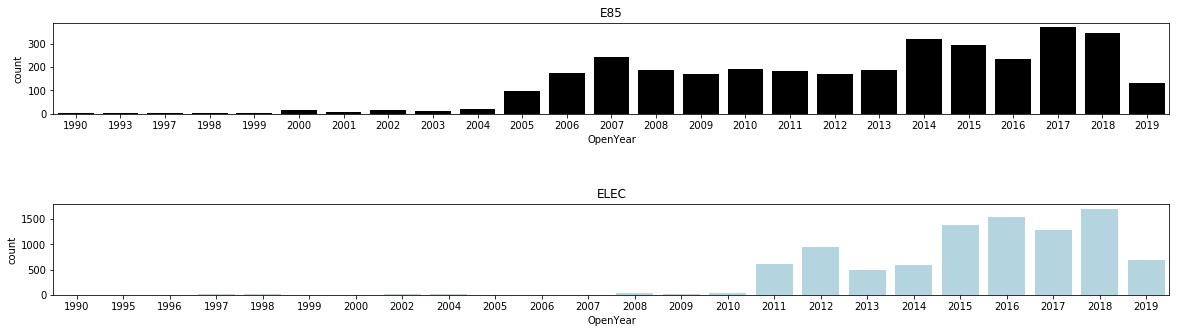

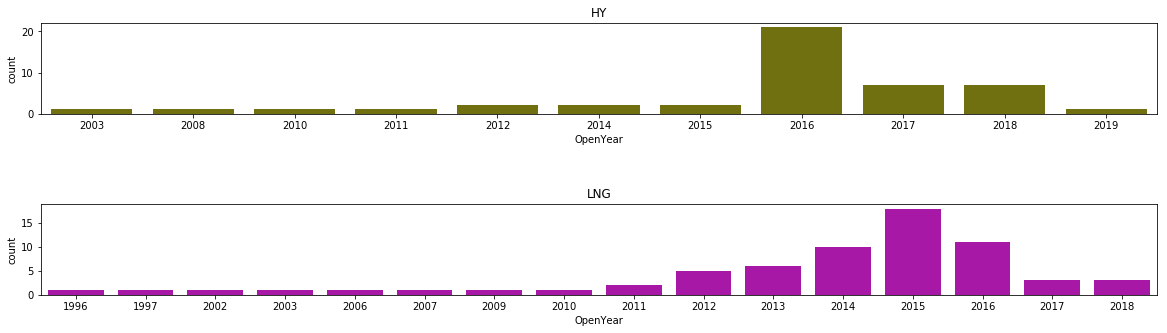

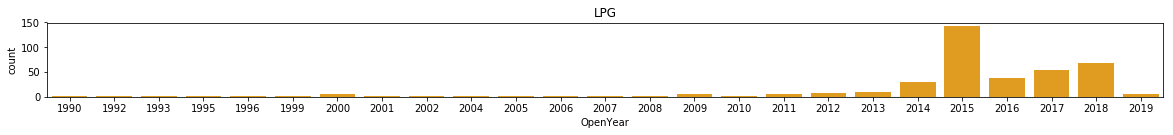

In [26]:
# Visualize growth in the number of stations over the years by fuel type
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2, 1, 1)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='BD')&(alt_fuels_df.OpenYear>=1990)],ax=ax1,color='b')
plt.title('BD')
ax2 = fig.add_subplot(2, 1, 2)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='CNG')&(alt_fuels_df.OpenYear>=1990)],ax=ax2,color='g')
plt.title('CNG')
fig.subplots_adjust(hspace=1,wspace=1)
plt.show();

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2, 1, 1)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='E85')&(alt_fuels_df.OpenYear>=1990)],ax=ax1,color='k')
plt.title('E85')
ax2 = fig.add_subplot(2, 1, 2)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='ELEC')&(alt_fuels_df.OpenYear>=1990)],ax=ax2,color='lightblue')
plt.title('ELEC')
fig.subplots_adjust(hspace=1,wspace=1)
plt.show();

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(2, 1, 1)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='HY')&(alt_fuels_df.OpenYear>=1990)],ax=ax1,color='olive')
plt.title('HY')
ax2 = fig.add_subplot(2, 1, 2)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='LNG')&(alt_fuels_df.OpenYear>=1990)],ax=ax2,color='m')
plt.title('LNG')
fig.subplots_adjust(hspace=1,wspace=1)
plt.show();

fig = plt.figure(figsize=(20,3))
ax1 = fig.add_subplot(2, 1, 1)
sns.countplot('OpenYear', data=alt_fuels_df[(alt_fuels_df.FuelTypeCode=='LPG')&(alt_fuels_df.OpenYear>=1990)],ax=ax1,color='orange')
plt.title('LPG')
plt.show()

Why there is decline in CNG and LNG in transportation industry?
With growing popularity of EV's combined with steady improvement in battery technology, the pervasiveness of the grid, and services to enable things like high-speed charging makes the EV's market inevitable.
Secondly, the high cost of filling stations has also kept a lid on CNG / LNG.
The CNG or LNG driven vehicles get worse mileage than regular gas or EV's. Nevertheless, CNG is increasingly touted as the fuel of the future for the U.S., in part because of declining prices and large reserves and growing demand.

<Figure size 1440x720 with 0 Axes>

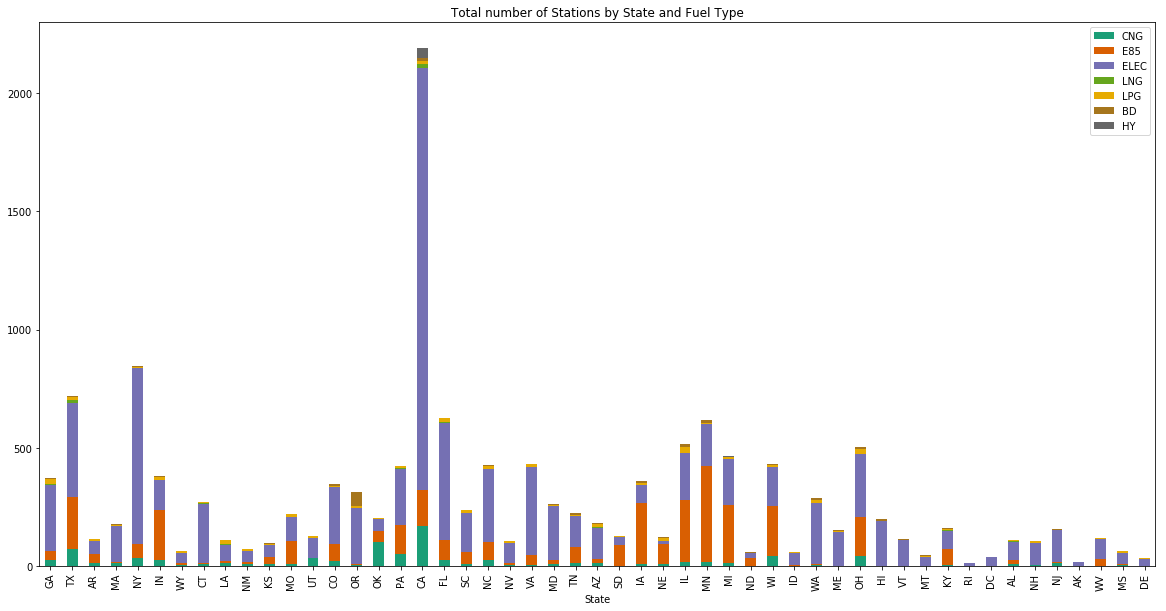

In [27]:
# Create a new dataframe fuel_state_df to contain only the ID, State and FuelTypeCode
fuel_state_df = alt_fuels_df[['ID','State','FuelTypeCode']].dropna()
# Plot Total Number of Stations by State and Fuel Type
figure(figsize=(20,10))
# Call function aggregate to get the data for stacking
aggregate('State','FuelTypeCode',fuel_state_df).plot(kind='bar',stacked=True,cmap='Dark2',figsize=(20,10),\
                                          title='Total number of Stations by State and Fuel Type')

The stacked bar plot shows the distribution of the different alternative fuel stations in each state.
CA has the most Electric, CNG, LNG and Hydrogen fuel stations. MN has the most E85 fuel stations. IL has the most LPG fuel stations. OR has the most BD fuel statitions.

In [28]:
# Create dataframe group_state_df grouping by State and FuelTypeCode
group_state_df = pd.DataFrame(fuel_state_df.groupby(['State','FuelTypeCode'])['ID'].count()).reset_index()
group_state_df.head()

,State,FuelTypeCode,ID
0,AK,CNG,1
1,AK,ELEC,16
2,AL,BD,2
3,AL,CNG,8
4,AL,E85,18


In [29]:
# Create new dataframe stgp_stack using pivot
stgp_stack = group_state_df.pivot(index='State', columns='FuelTypeCode', values='ID').fillna(0).astype(numpy.int64)

In [30]:
# Reset index to be state
stgp_stack.columns = ['BD','CNG','E85','ELEC','HY','LNG','LPG']
stgp_stack.reset_index('State')

,State,BD,CNG,E85,ELEC,HY,LNG,LPG
0,AK,0,1,0,16,0,0,0
1,AL,2,8,18,77,0,2,4
2,AR,1,11,42,51,0,1,8
3,AZ,3,12,19,131,0,3,13
4,CA,11,168,155,1781,41,18,15
5,CO,6,21,73,241,0,0,5
6,CT,1,9,3,252,1,1,4
7,DC,0,0,1,39,0,0,0
8,DE,0,1,0,27,0,0,4
9,FL,3,26,84,496,0,2,17


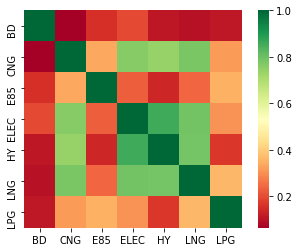

In [31]:
sns.heatmap(stgp_stack.corr(), square=True, cmap='RdYlGn')

The heat map shows correlation among various alternative fuel stations by type. It shows high correlation amongst CNG, HY and ELEC. There is no correlation amongst BD, E85 and LPG.

In [32]:
# Create a new column for State to be used for plotting
stgp_stack['State']=stgp_stack.index
stgp_stack.head()

,BD,CNG,E85,ELEC,HY,LNG,LPG,State
State,,,,,,,,
AK,0,1,0,16,0,0,0,AK
AL,2,8,18,77,0,2,4,AL
AR,1,11,42,51,0,1,8,AR
AZ,3,12,19,131,0,3,13,AZ
CA,11,168,155,1781,41,18,15,CA


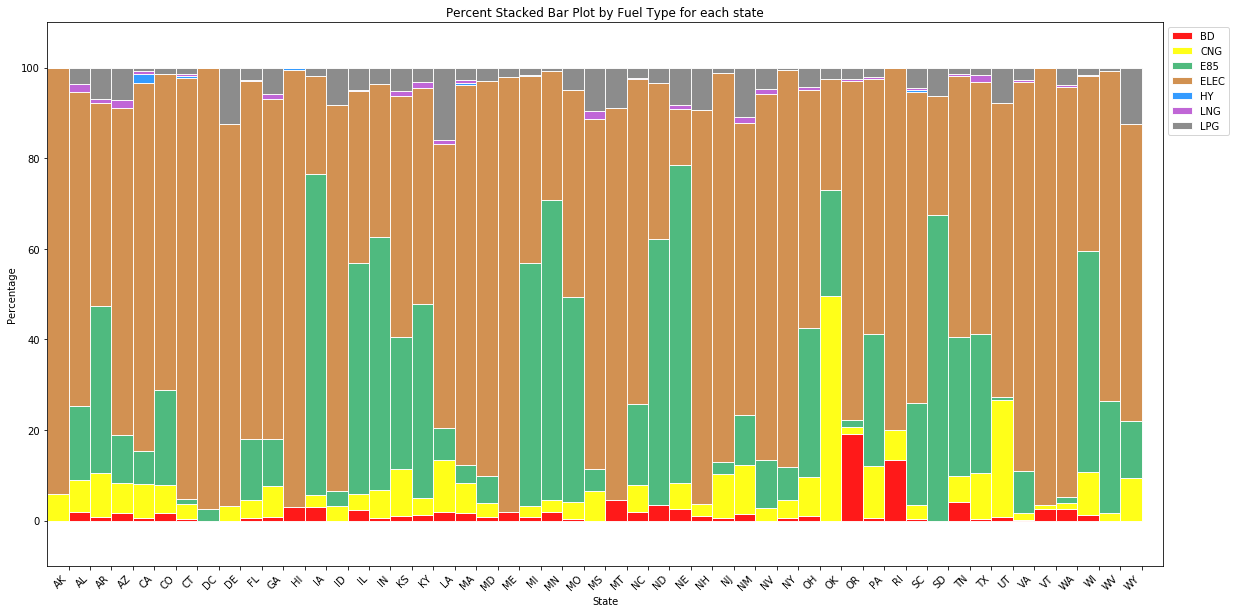

In [33]:
# Create a figure with a single subplot
f, ax = plt.subplots(1, figsize=(20,10))

# Set bar width at 1
bar_width = 1

# positions of the left bar-boundaries
bar_l = [i for i in range(len(stgp_stack['BD']))] 

# positions of the x-axis ticks (center of the bars as bar labels)
tick_pos = [i+(bar_width/2) for i in bar_l] 

# Create the total sstations for each state
totals = [i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(stgp_stack['BD'], stgp_stack['CNG'], stgp_stack['E85'],\
                                 stgp_stack['ELEC'],stgp_stack['HY'],stgp_stack['LNG'],stgp_stack['LPG'])]

# Create the percentage of the total number of stations the BD count for each state
PerBD = [i / j * 100 for  i,j in zip(stgp_stack['BD'], totals)]

# Create the percentage of the total number of stations the CNG count for each state
PerCNG = [i / j * 100 for  i,j in zip(stgp_stack['CNG'], totals)]

# Create the percentage of the total number of stations the E85 count for each state
PerE85 = [i / j * 100 for  i,j in zip(stgp_stack['E85'], totals)]

# Create the percentage of the total number of stations the ELEC count for each state
PerELEC = [i / j * 100 for  i,j in zip(stgp_stack['ELEC'], totals)]

# Create the percentage of the total number of stations the HY count for each state
PerHY = [i / j * 100 for  i,j in zip(stgp_stack['HY'], totals)]

# Create the percentage of the total number of stations the LNG count for each state
PerLNG = [i / j * 100 for  i,j in zip(stgp_stack['LNG'], totals)]

# Create the percentage of the total number of stations the LPG count for each state
PerLPG = [i / j * 100 for  i,j in zip(stgp_stack['LPG'], totals)]

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using pre_rel data
       PerBD, 
       # labeled 
       label='BD', 
       # with alpha
       alpha=0.9, 
       # with color
       color='r',
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using mid_rel data
       PerCNG, 
       # with pre_rel
       bottom=PerBD, 
       # labeled 
       label='CNG', 
       # with alpha
       alpha=0.9, 
       # with color
       color='yellow', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       PerE85, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j for i,j in zip(PerBD, PerCNG)], 
       # labeled 
       label='E85',
       # with alpha
       alpha=0.9, 
       # with color
       color='#3CB371', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       PerELEC, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k for i,j,k in zip(PerBD, PerCNG, PerE85)], 
       # labeled 
       label='ELEC',
       # with alpha
       alpha=0.9, 
       # with color
       color='#CD853F', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       PerHY, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k+l for i,j,k,l in zip(PerBD, PerCNG, PerE85,PerELEC)], 
       # labeled 
       label='HY',
       # with alpha
       alpha=0.9, 
       # with color
       color='#1E90FF', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       PerLNG, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k+l+m for i,j,k,l,m in zip(PerBD, PerCNG, PerE85,PerELEC,PerHY)], 
       # labeled 
       label='LNG',
       # with alpha
       alpha=0.9, 
       # with color
       color='#BA55D3', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Create a bar chart in position bar_1
ax.bar(bar_l, 
       # using post_rel data
       PerLPG, 
       # with pre_rel and mid_rel on bottom
       bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(PerBD, PerCNG, PerE85,PerELEC,PerHY,PerLNG)], 
       # labeled 
       label='LPG',
       # with alpha
       alpha=0.9, 
       # with color
       color='#808080', 
       # with bar width
       width=bar_width,
       # with border color
       edgecolor='white'
       )

# Set the ticks to be first names
plt.xticks(tick_pos, stgp_stack['State'])
ax.set_ylabel("Percentage")
ax.set_xlabel("")

# Let the borders of the graphic
plt.xlim([min(tick_pos)-bar_width, max(tick_pos)+bar_width])
plt.ylim(-10, 110)

# rotate axis labels
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# shot plot
plt.xlabel('State')
plt.title('Percent Stacked Bar Plot by Fuel Type for each state')
plt.show()

The plot above shows the percentage distribution of alternative fuels in each state.   
           
In general electric fuel stations are predominantly higher in proportion in most of the states except for those where ethanol type fuel is produced more which is supported by the corn fields. This can be seen in states like NE, IA, MN, SD and WI.     
       
State regulations and incentives are spurring CNG station investment and vehicle adoption. It is no accident that states like Oklahoma and Utah have the highest concentrations of CNG stations and vehicles. Oklahoma provides waivers of state tax liability to in-state suppliers of CNG station components. Utah requires that CNG be supplied by regulated utilities (effectively capping prices). 

CA has adopted HY based fuel to meet its long term climate, clean air and public health goals. HY fuel stations are clustered in major metropolitan cities in CA that are also tech savvy. CA has about 40 HY fuel stations for about 6500 fuel cell cars as of May 2019. There is now 1 retail station per 163 vehicles. Though it is in growing trend it is expected to not reach the states set goal of 100 HY fueling stations by 2020.

In [34]:
fuel_state_df.head()

,ID,State,FuelTypeCode
0,42,GA,CNG
1,72,TX,CNG
2,73,AR,CNG
3,81,MA,CNG
4,83,MA,CNG


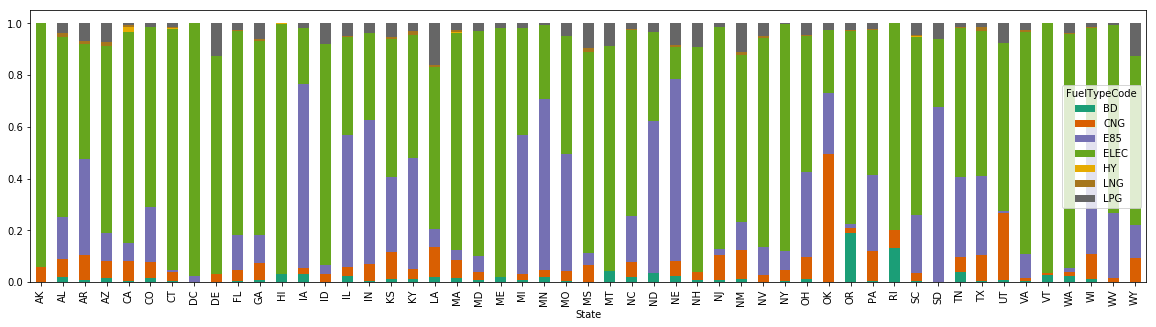

In [35]:
# Create the plot above using value_counts
props = fuel_state_df.groupby(['State'])['FuelTypeCode'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', cmap = 'Dark2',figsize=(20,5))

A different approach to the above percentage plot!

In [36]:
# Create Dataframe st_df to contain ID and OpenYear for grouping stations
st_df=alt_fuels_df[['ID','OpenYear']]
# Create Dataframe st_cnt_year to contain Station Count by OpenYear 
st_cnt_year = st_df.groupby(['OpenYear']).ID.agg('count').to_frame('StCount').reset_index()
st_cnt_year = st_cnt_year[st_cnt_year.OpenYear >= 2000]

In [37]:
st_cnt_year['Type'] = 'S'
st_cnt_year = st_cnt_year.rename(columns ={'OpenYear':'Year','StCount':'Count'})

In [38]:
st_total_df = alt_fuels_df[['ID','OpenYear','FuelTypeCode']]
st_total_df = st_total_df[st_total_df.OpenYear >= 1990]
st_tot_df= st_total_df.groupby(['OpenYear','FuelTypeCode']).ID.agg('count').to_frame('StCount').reset_index()
st_tot_df = st_tot_df[st_tot_df.OpenYear >= 1990]
st_tot_df = st_tot_df.rename(columns ={'OpenYear':'Year','StCount':'Count','FuelTypeCode':'Type'})

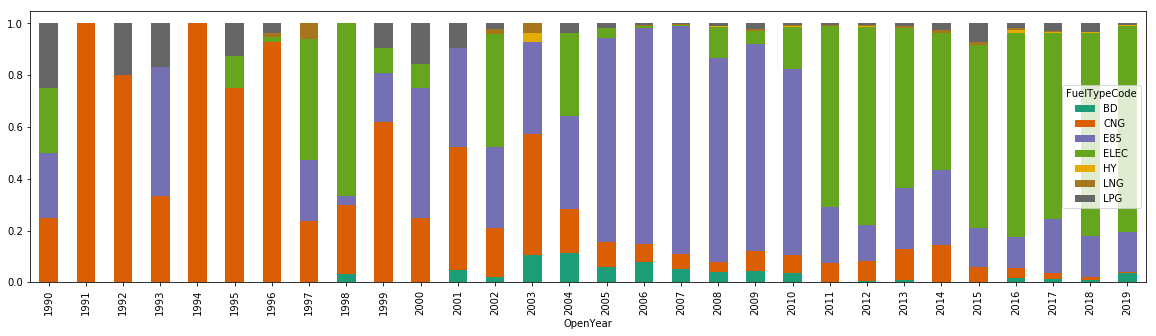

In [39]:
# Create the plot above using value_counts
st_prop_year_df = st_total_df.groupby(['OpenYear'])['FuelTypeCode'].value_counts(normalize=True).unstack()
st_prop_year_df.plot(kind='bar', stacked='True', cmap = 'Dark2',figsize=(20,5))

In 90's the majority of alternative fuels stations opened were Biodiesel based which has shifted towards electric and E85 type alternative fuels mainly due to advancement in technology and affordable cost. In the past decade it is distictly focused on growth towards electric based stations. This combined with higher number of electric vehicles justify the growth of number of stations.

In [40]:
st_tot_df['SV_Type'] = 'S'

In [41]:
# Create dataframes for each fuel type for stations
st_e85_df = st_tot_df[(st_tot_df.Type=='E85') & (st_tot_df.Year >=2000)]
st_elec_df = st_tot_df[(st_tot_df.Type=='ELEC') & (st_tot_df.Year >=2000)]
st_bd_df = st_tot_df[(st_tot_df.Type=='BD') & (st_tot_df.Year >=2000)]
st_cng_df = st_tot_df[(st_tot_df.Type=='CNG') & (st_tot_df.Year >=2000)]
st_lpg_df = st_tot_df[(st_tot_df.Type=='LPG') & (st_tot_df.Year >=2000)]
st_lng_df = st_tot_df[(st_tot_df.Type=='LNG') & (st_tot_df.Year >=2000)]
st_hy_df = st_tot_df[(st_tot_df.Type=='HY') & (st_tot_df.Year >=2000)]

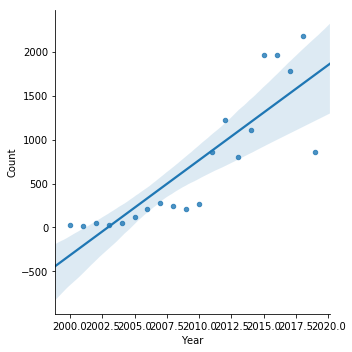

In [42]:
#sns.regplot(st_cnt_year.Year,st_cnt_year.Count)
# Perform linear regression 
a, b = np.polyfit(st_cnt_year.Year,st_cnt_year.Count, 1)
# Plot regression
sns.lmplot(x = 'Year',y = 'Count', data = st_cnt_year,scatter_kws={"s": 20})

Over the last 15 years the number of alternative fuel stations is in a steeper growth that is at a rate of 100 to 125 fuel stations year over year.

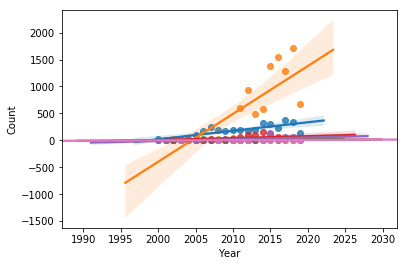

In [43]:
sns.regplot(st_e85_df.Year,st_e85_df.Count)
sns.regplot(st_elec_df.Year,st_elec_df.Count)
sns.regplot(st_bd_df.Year,st_bd_df.Count)
sns.regplot(st_cng_df.Year,st_cng_df.Count)
sns.regplot(st_lpg_df.Year,st_lpg_df.Count)
sns.regplot(st_lng_df.Year,st_lng_df.Count)
sns.regplot(st_hy_df.Year,st_hy_df.Count)

The regression plot by fuel type is not clear due to overlapping. To provide clarity we will use log scale.

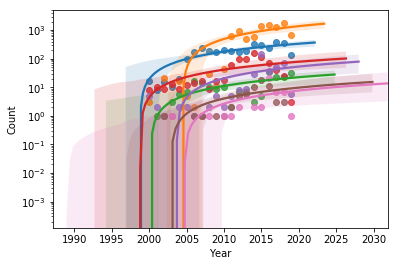

In [44]:
ax1=sns.regplot(st_e85_df.Year,st_e85_df.Count)
ax2=sns.regplot(st_elec_df.Year,st_elec_df.Count)
ax3=sns.regplot(st_bd_df.Year,st_bd_df.Count)
ax4=sns.regplot(st_cng_df.Year,st_cng_df.Count)
ax5=sns.regplot(st_lpg_df.Year,st_lpg_df.Count)
ax6=sns.regplot(st_lng_df.Year,st_lng_df.Count)
ax7=sns.regplot(st_hy_df.Year,st_hy_df.Count)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')

Regression plot with log scale on y axis enables the separation between various fuel type stations data points for better visualization.

Text(0.5, 0.98, 'Regression Plot - Stations by Fuel Type')

<Figure size 2160x360 with 0 Axes>

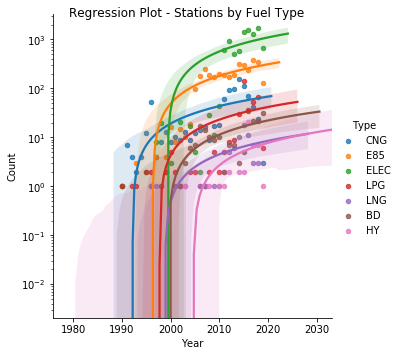

In [45]:
# Use logarithmic scale for better view
figure(figsize=(30,5))
grid = sns.lmplot(x="Year", y="Count", hue="Type", data=st_tot_df,fit_reg=True, scatter_kws={"s": 20})
grid.set(yscale="log")
fig=grid.fig
fig.suptitle("Regression Plot - Stations by Fuel Type")

sns lm plot to show the above regression.

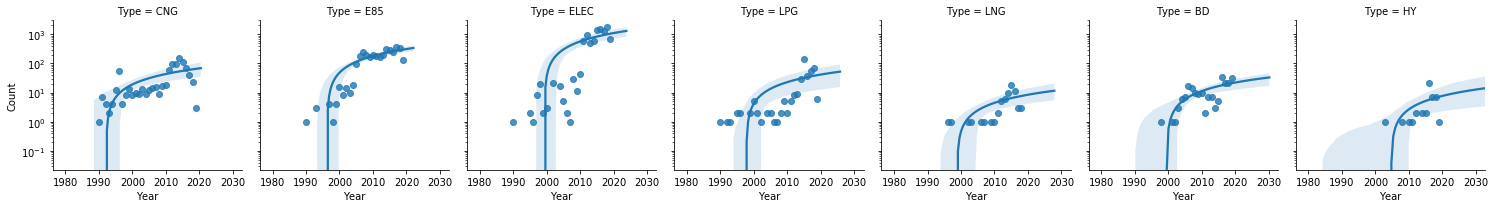

In [46]:
g = sns.FacetGrid(st_tot_df, col="Type", margin_titles=True)
g.map(sns.regplot, "Year", "Count", fit_reg=True)
g.set(yscale='log')

Individual regression plots of alternative fuel stations for each fuel type.

## Vehichle Data

In [47]:
veh_sales_df.head()

,Year,E85,ELEC,BD,CNG,LPG,LNG,HY,Total
0,2004,47643,19915,31922,76257,31338,0,23,207098
1,2005,72899,26017,52275,49271,21117,1873,42,223494
2,2006,221834,53367,91584,57458,25543,2271,72,452129
3,2007,385671,87882,98785,55021,23628,1731,86,652804
4,2008,524169,116089,17222,51121,22260,2053,75,732989


In [48]:
# Create dataframes for each fuel type and Create a new column in the data frames to include Type
e85_df = veh_sales_df[['Year','E85']]
elec_df = veh_sales_df[['Year','ELEC']]
bd_df = veh_sales_df[['Year','BD']]
cng_df = veh_sales_df[['Year','CNG']]
lpg_df = veh_sales_df[['Year','LPG']]
lng_df = veh_sales_df[['Year','LNG']]
hy_df = veh_sales_df[['Year','HY']]
tot_df = veh_sales_df[['Year','Total']]

In [49]:
e85_df['Type']='E85'
elec_df['Type']='ELEC'
bd_df['Type']='BD'
cng_df['Type']='CNG'
lpg_df['Type']='LPG'
lng_df['Type']='LNG'
hy_df['Type']='HY'
tot_df['Type']='V'

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [50]:
e85_df = e85_df.rename(columns ={'E85':'Count'})
elec_df = elec_df.rename(columns ={'ELEC':'Count'})
bd_df= bd_df.rename(columns={'BD':'Count'})
cng_df = cng_df.rename(columns ={'CNG':'Count'})
lpg_df = lpg_df.rename(columns ={'LPG':'Count'})
lng_df = lng_df.rename(columns ={'LNG':'Count'})
hy_df = hy_df.rename(columns ={'HY':'Count'})
tot_df = tot_df.rename(columns={'Total':'Count'})

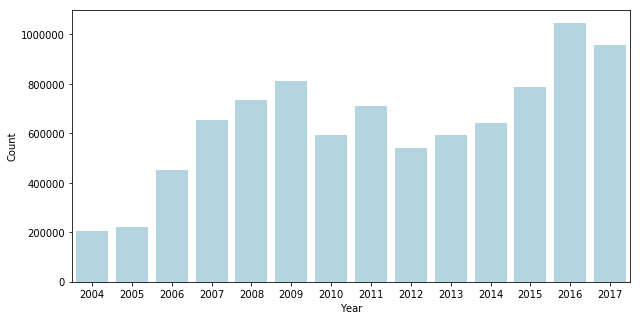

In [51]:
figure(figsize=(10,5))
sns.barplot(x='Year', y='Count', data=tot_df, color='lightblue')

In [52]:
# Combine all fuel types to one dataframe
frames = [e85_df,bd_df,cng_df,hy_df,lng_df,lpg_df,elec_df]
combined_df = pd.concat(frames)
combined_df['SV_Type']='V'

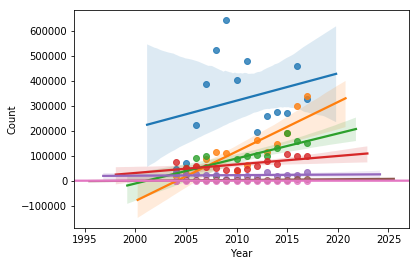

In [53]:
sns.regplot(e85_df.Year,e85_df.Count)
sns.regplot(elec_df.Year,elec_df.Count)
sns.regplot(bd_df.Year,bd_df.Count)
sns.regplot(cng_df.Year,cng_df.Count)
sns.regplot(lpg_df.Year,lpg_df.Count)
sns.regplot(lng_df.Year,lng_df.Count)
sns.regplot(hy_df.Year,hy_df.Count)

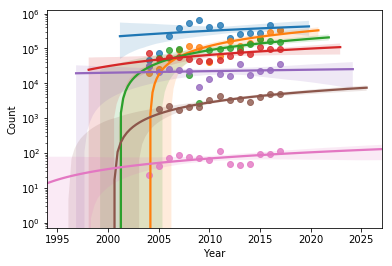

In [54]:
ax1=sns.regplot(e85_df.Year,e85_df.Count)
ax2=sns.regplot(elec_df.Year,elec_df.Count)
ax3=sns.regplot(bd_df.Year,bd_df.Count)
ax4=sns.regplot(cng_df.Year,cng_df.Count)
ax5=sns.regplot(lpg_df.Year,lpg_df.Count)
ax6=sns.regplot(lng_df.Year,lng_df.Count)
ax7=sns.regplot(hy_df.Year,hy_df.Count)
ax1.set_yscale('log')
ax2.set_yscale('log')
ax3.set_yscale('log')
ax4.set_yscale('log')
ax5.set_yscale('log')
ax6.set_yscale('log')
ax7.set_yscale('log')

Regression plot with log scale for vehicles equipped with alternative fuels shows an increase in growth trend which coincides with the growth trend of number of alternative fuel stations.

<Figure size 2160x576 with 0 Axes>

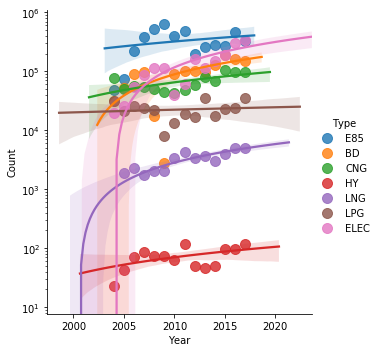

In [55]:
# Use logarithmic scale for better view
figure(figsize=(30,8))
grid = sns.lmplot(x="Year", y="Count", hue="Type", data=combined_df[combined_df.Year>1980],fit_reg=True, scatter_kws={"s": 100})
grid.set(yscale="log")

sns lmplot for the same vehicle data as the above.

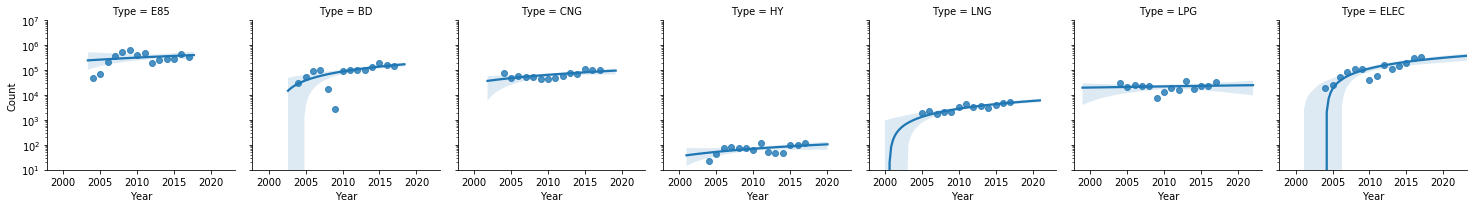

In [56]:
g = sns.FacetGrid(combined_df[combined_df.Year>1980], col="Type", margin_titles=True)
g.map(sns.regplot, "Year", "Count", fit_reg=True)
g.set(yscale='log')
g.set(ylim=(10,10000000))

Individual regression plots for vehicles equipped with alternative fuels shows growh trend except for CNG and LNG that flattens which is again supported by stagnation in stations trend.

In [57]:
# Append total stations by year with total vehicles by year
result_df = tot_df.append(st_cnt_year)

In [58]:
# Append total stations by year and Fuel Type with total vehicles by year and Fuel Type
result_type_df = combined_df.append(st_tot_df)

In [59]:
result_corr_df = pd.merge(st_cnt_year, tot_df, how='left', on='Year')
result_corr_df.fillna(0)
result_corr_df.Count_y = pd.to_numeric(result_corr_df.Count_y).fillna(0).astype(int)
result_corr_df = result_corr_df[result_corr_df.Count_y>0]
result_corr_df.head()

,Year,Count_x,Type_x,Count_y,Type_y
4,2004,53,S,207098,V
5,2005,122,S,223494,V
6,2006,212,S,452129,V
7,2007,276,S,652804,V
8,2008,241,S,732989,V


<Figure size 1440x576 with 0 Axes>

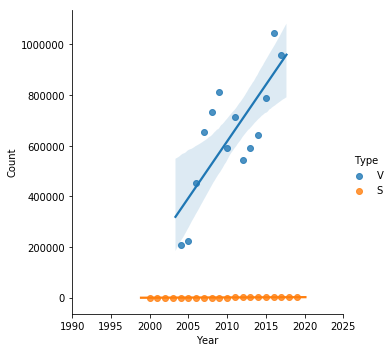

In [60]:
figure(figsize=(20,8))
a, b = np.polyfit(result_df.Year,result_df.Count, 1)
g = sns.lmplot('Year', 'Count', result_df, hue='Type', sharex=False, sharey=False)
g.set(xlim=(1990, 2025))

Regression plot to view trend of stations and vehicles. We will try log scale to have a better visualization.

<Figure size 1440x576 with 0 Axes>

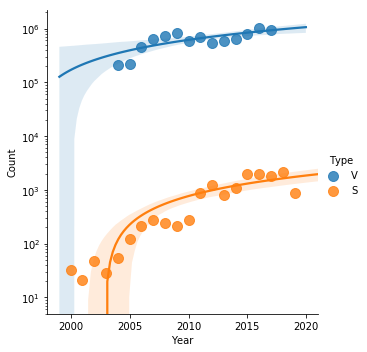

In [61]:
figure(figsize=(20,8))
grid = sns.lmplot(x="Year", y="Count", hue="Type", data=result_df[result_df.Year>1980],  scatter_kws={"s": 100})
grid.set(yscale="log")

We can see the trend between the number of alternative fuel stations and vehicles equipped with alternative fuels being parallel to each other from the year 2005 onwards showing strong correlation.

Look at the correlation between number of alternative fuel stations and number of alternative fuel vehicles across US using the scipy stats pearsonr function that returns the pearsonr coefficient and the pvalue.      
Selecting an signifance level of 0.05, and so if the pvalue is less than 0.05, we can find out if the correlation coefficienct returned is significant.

In [62]:
# Calculate the pearsonr coefficient between the stations and vehicles
scipy.stats.pearsonr(result_corr_df.Count_x, result_corr_df.Count_y)

(0.6822392170959737, 0.007186427141207331)

With pearsonr coefficient of about 68% and p value of 0.007 which is less than the significance level of 0.05 we can conclude that the correlation is significant.

Regression plot to show correlation between number of stations and number of vehicles.

Text(0.5, 1.0, 'Station Count vs Vehicle Count')

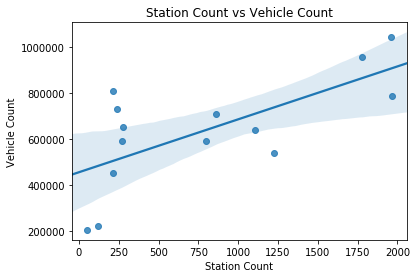

In [63]:
sns.regplot("Count_x", "Count_y",data=result_corr_df, fit_reg=True)
xlabel('Station Count')
ylabel('Vehicle Count')
title('Station Count vs Vehicle Count')

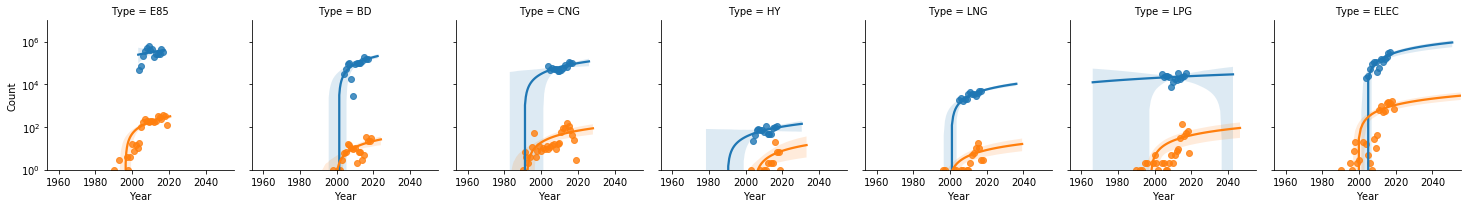

In [64]:
g = sns.FacetGrid(result_type_df, col="Type",hue='SV_Type', margin_titles=True)
g.map(sns.regplot, "Year", "Count", fit_reg=True)
g.set(yscale='log')
g.set(ylim=(1,10000000))

Individual regression plots to see the trend between the number of stations and number of vehicles for each fuel type. Strong correlation seems to be the case with alternative fuel types like BD, CNG, LNG and ELEC whereas with HY, the number of stations seem to progress at a higher rate than the number of HY fuel cell based vehicles.

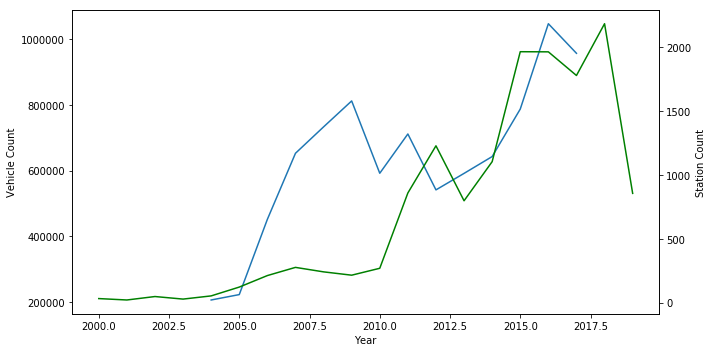

In [65]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(tot_df.Year,tot_df.Count)
ax1.set_xlabel('Year')
ax1.set_ylabel('Vehicle Count')
ax2 = ax1.twinx() 
ax2.plot(st_cnt_year.Year,st_cnt_year.Count, color='g')
ax2.set_ylabel('Station Count')
fig.tight_layout() 
plt.show()

We can clearly see that from 2005 onwards the alternative fuels station count and alternative fuels vehicle count kind of follow each other showing that some correlation exists between them.

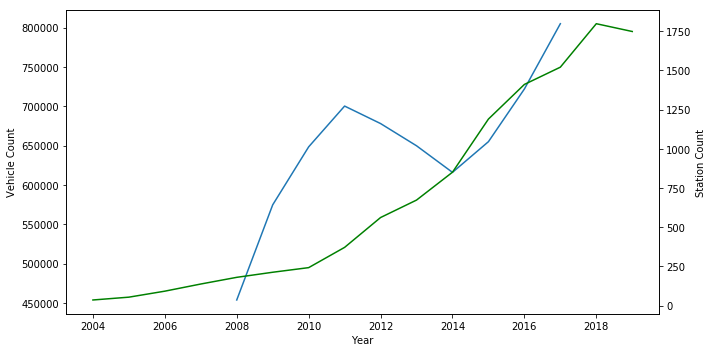

In [66]:
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(tot_df.Year,tot_df.Count.rolling(5).mean())
ax1.set_xlabel('Year')
ax1.set_ylabel('Vehicle Count')
ax2 = ax1.twinx()
ax2.plot(st_cnt_year.Year,st_cnt_year.Count.rolling(5).mean(), color='g')
ax2.set_ylabel('Station Count')
fig.tight_layout()  
plt.show()

This plot shows the rolling mean of the previous plot with lines being smoothed out. Overall, the number of alternative fuel stations and alternative fuel vehicles seems to be on the rise in the past 15 years.

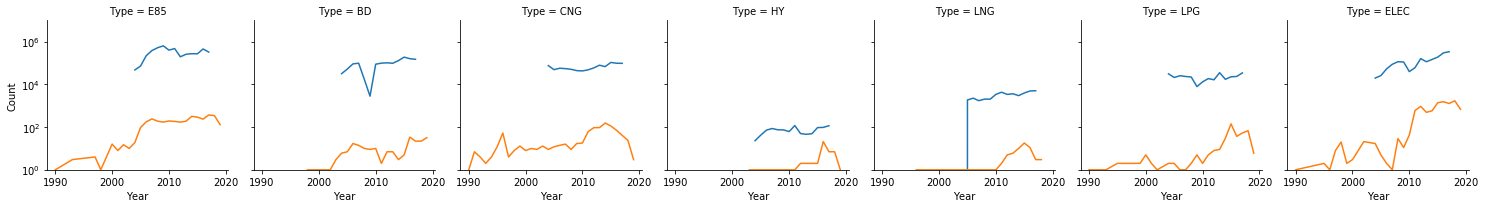

In [67]:
g = sns.FacetGrid(result_type_df, col="Type",hue='SV_Type', margin_titles=True, despine=True)
g.map(sns.lineplot, "Year", "Count")
g.set(yscale='log')
g.set(ylim=(1,10000000))

These individual plots clearly shows increase in E85, BD and Electric vehicles and stations while CNG, LNG, LPG and HY show decline in the number of stations.

## Future Work

. Build a model to predict number of alternative fuel stations and number of alternative fuel equipped vehicles for any given future year - either by fuel type or by total.

. Build a model to predict best location for the future alternative fuel station.
     
. Assessing individual alternative fuel cost trend's effect on the rate of change in the number of alternative fuel stations and vehicles equipped with that particular fuel type.